In [444]:
import numpy as np
import matplotlib.pyplot as plt
from TDMA import TDMA   

In [445]:

# --- Load data ---
xc = np.loadtxt('xc.dat')   # grid lines in x (faces) length = nim1
yc = np.loadtxt('yc.dat')   # grid lines in y (faces) length = njm1
u = np.loadtxt('u.dat')     # velocities in MATLAB column-major ordering, length = ni*nj
v = np.loadtxt('v.dat')

# --- Grid bookkeeping (match your original logic) ---
nim1 = len(xc)        # number of grid-lines / faces in x
ni = nim1 + 1         # total nodes (including boundaries) in x-direction
njm1 = len(yc)
nj = njm1 + 1

# reshape velocity arrays (MATLAB column-major => order='F')
u2d = np.reshape(u, (ni, nj), order='F')
v2d = np.reshape(v, (ni, nj), order='F')


In [446]:
# plt.plot(yc)

In [447]:
## Paraameters

rho = 1
k = 1
# cp = k*50
gamma = 0.02
Ua = 1
Vd = 0
Ub = 0
Uc = 1

T_right_boundary_value = 0
T_left_boundary_value = 20
T_top_boundary_value = 0
T_bottom_boundary_value = 10

ep = 1e-5 # Some small value i am adding for division so no inf 

In [448]:
def local_Pe(rho, u_e, u_w, v_n, v_s, del_xe, del_xw, del_xn, del_xs, k_over_cp=1/50):
    factor = rho / k_over_cp  # since k/cp = 1/50

    Pe_e = factor * u_e * del_xe
    Pe_w = factor * u_w * del_xw
    Pe_n = factor * v_n * del_xn
    Pe_s = factor * v_s * del_xs

    Pe_x = (Pe_e + Pe_w) / 2
    Pe_y = (Pe_n + Pe_s) / 2

    Pe_local = np.sqrt(Pe_x**2 + Pe_y**2)

    return Pe_local

In [449]:
Nx = 26
Ny = 26
grid_shape = [Nx, Ny] # x, y

N = grid_shape[0] * grid_shape[1]
A = np.zeros((N, N))
B = np.zeros(N)



In [450]:
Pe_history = []

for y in range(grid_shape[1]):
    a_W_line = np.zeros(grid_shape[0])
    a_P_line = np.zeros(grid_shape[0])
    a_E_line = np.zeros(grid_shape[0])
    b_line   = np.zeros(grid_shape[0])

    for x in range(grid_shape[0]):
        n = y * grid_shape[0] + x

        del_xe, del_xw, del_xn, del_xs = [None]*4
        a_e = a_w = a_n = a_s = 0.0

        if x == 0: 
            del_xw = xc[0]/2
        if x == grid_shape[0]-1:
            del_xe = xc[-1]/2
        if y == 0: 
            del_xs = yc[0]/2
        if y == grid_shape[1]-1:
            del_xn = yc[-1]/2

        # if x != 0 and x != grid_shape[0]-1 and y != 0 and y != grid_shape[1]-1:
        # if del_xw is None: del_xw = xc[x] - xc[x-1]
        # if del_xe is None: del_xe = xc[x+1] - xc[x]
        # if del_xs is None: del_xs = yc[y] - yc[y - 1]
        # if del_xn is None: del_xn = yc[y + 1] - yc[y]

        if del_xw is None and x > 0:
            del_xw = xc[x] - xc[x-1]
        if del_xe is None and x < grid_shape[0]-1:
            del_xe = xc[x+1] - xc[x]
        if del_xs is None and y > 0:
            del_xs = yc[y] - yc[y-1]
        if del_xn is None and y < grid_shape[1]-1:
            del_xn = yc[y+1] - yc[y]
        
        # Pe = local_Pe(rho, u_e = u2d[y, x], u_w = u2d[y+1, x], v_n = v2d[y, x], v_s = v2d[y, x+1], del_xe = del_xe, del_xw = del_xw, del_xn = del_xn, del_xs = del_xs)
        Pe = local_Pe(
                rho,
                u_e = u2d[y, x+1],
                u_w = u2d[y, x],
                v_n = v2d[y, x],
                v_s = v2d[y+1, x], 
                del_xe = del_xe,
                del_xw = del_xw,
                del_xn = del_xn,
                del_xs = del_xs
            )
        Pe_history.append(Pe)
    
        # Convection Terms
        Fe = rho * u2d[y, x+1] if x < grid_shape[0]-1 else 0.0
        Fs = rho * v2d[y+1, x] if y < grid_shape[1]-1 else 0.0
        Fw = rho * u2d[y, x]   if x > 0 else 0.0
        Fn = rho * v2d[y, x]   if y > 0 else 0.0 

        # Diffusion Terms
        Dn = gamma / (del_xn + ep)
        Ds = gamma / (del_xs + ep)
        De = gamma / (del_xe + ep)
        Dw = gamma / (del_xw + ep) 
        
        if x == 0 and y == 0:
            Fw = rho * Ua
            
        if y == 0 and x == 13:
            Fs = rho * Vd
        
        if y == grid_shape[1]-1 and x == 0:
            Fw = rho * Ub

        if y == grid_shape[1]-1 and x == grid_shape[0]-1:
            Fw = rho * Uc
        # Pe = 10
        if Pe < 2:
                # CD Scheme

                a_n = -Fn/2 + Dn
                a_s =  Fs/2 + Ds
                a_e = -Fe/2 + De
                a_w =  Fw/2 + Dw

                ap = a_n + a_s + a_e + a_w
                
        else:
            # Upwind Scheme

            a_e = De if Fe>0 else De + abs(Fe)
            a_w = Dw + Fw if Fw>0 else Dw
            a_n = Dn if Fn>0 else Dn + abs(Fn)
            a_s = Ds + Fs if Fs>0 else Ds
            
        a_p = a_e + a_w + a_n + a_s + (Fe - Fw + Fn - Fs)

        

       


In [451]:
a_e

np.float64(0.019999800001999978)

In [452]:
# phi_vec = np.linalg.solve(A, B)
# Ts = phi_vec.reshape(grid_shape[1], grid_shape[0])  # rows=y, cols=x

In [453]:
T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 

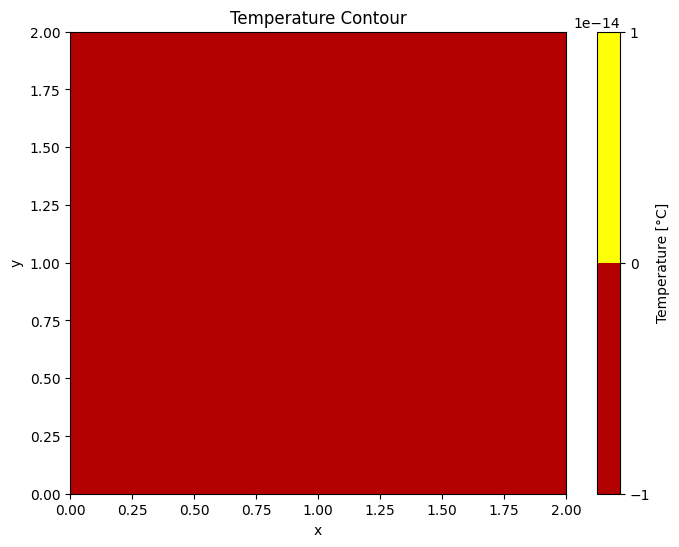

In [454]:
Ts_plot = Ts.T  # now shape (Ny, Nx)
Ts_plot = T
# Create meshgrid for coordinates
X, Y = np.meshgrid(xc, yc)  # xc = x-coordinates, yc = y-coordinates

# Contour plot
plt.figure(figsize=(8,6))
contour = plt.contourf(X, Y, Ts_plot, 20, cmap='hot')  # 20 contour levels
plt.colorbar(contour, label='Temperature [°C]')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Temperature Contour')
plt.show()

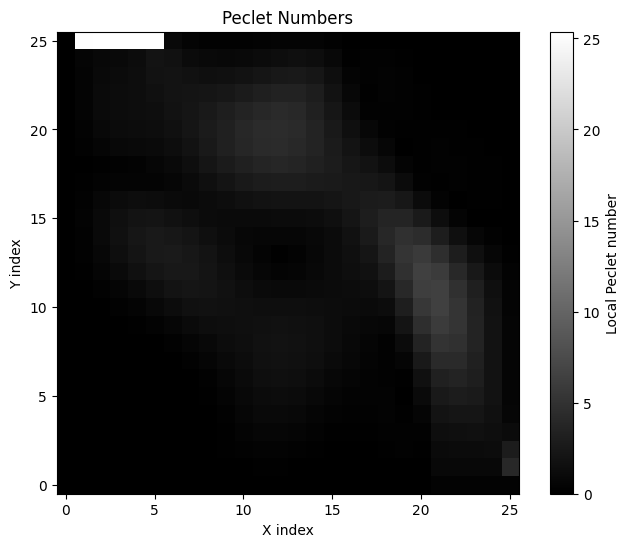

In [455]:
Pe_grid = np.array(Pe_history).reshape(grid_shape[0], grid_shape[1])
plt.figure(figsize=(8,6))
plt.imshow(Pe_grid.T, origin='lower', cmap='gray', interpolation='none')  # transpose for correct orientation
plt.colorbar(label='Local Peclet number')
plt.xlabel('X index')
plt.ylabel('Y index')
plt.title('Peclet Numbers')
plt.show()

Iteration 0: Max residual = 3.50e+01
Iteration 50: Max residual = 3.17e-01
Iteration 100: Max residual = 3.40e-02
Iteration 150: Max residual = 6.49e-03
Iteration 200: Max residual = 2.83e-03
Iteration 250: Max residual = 1.28e-03
Iteration 300: Max residual = 5.77e-04
Iteration 350: Max residual = 2.62e-04
Iteration 400: Max residual = 1.18e-04
Iteration 450: Max residual = 5.37e-05
Iteration 500: Max residual = 2.43e-05
Iteration 550: Max residual = 1.10e-05
Iteration 600: Max residual = 4.99e-06
Iteration 650: Max residual = 2.26e-06
Iteration 700: Max residual = 1.02e-06

Converged in 703 iterations!


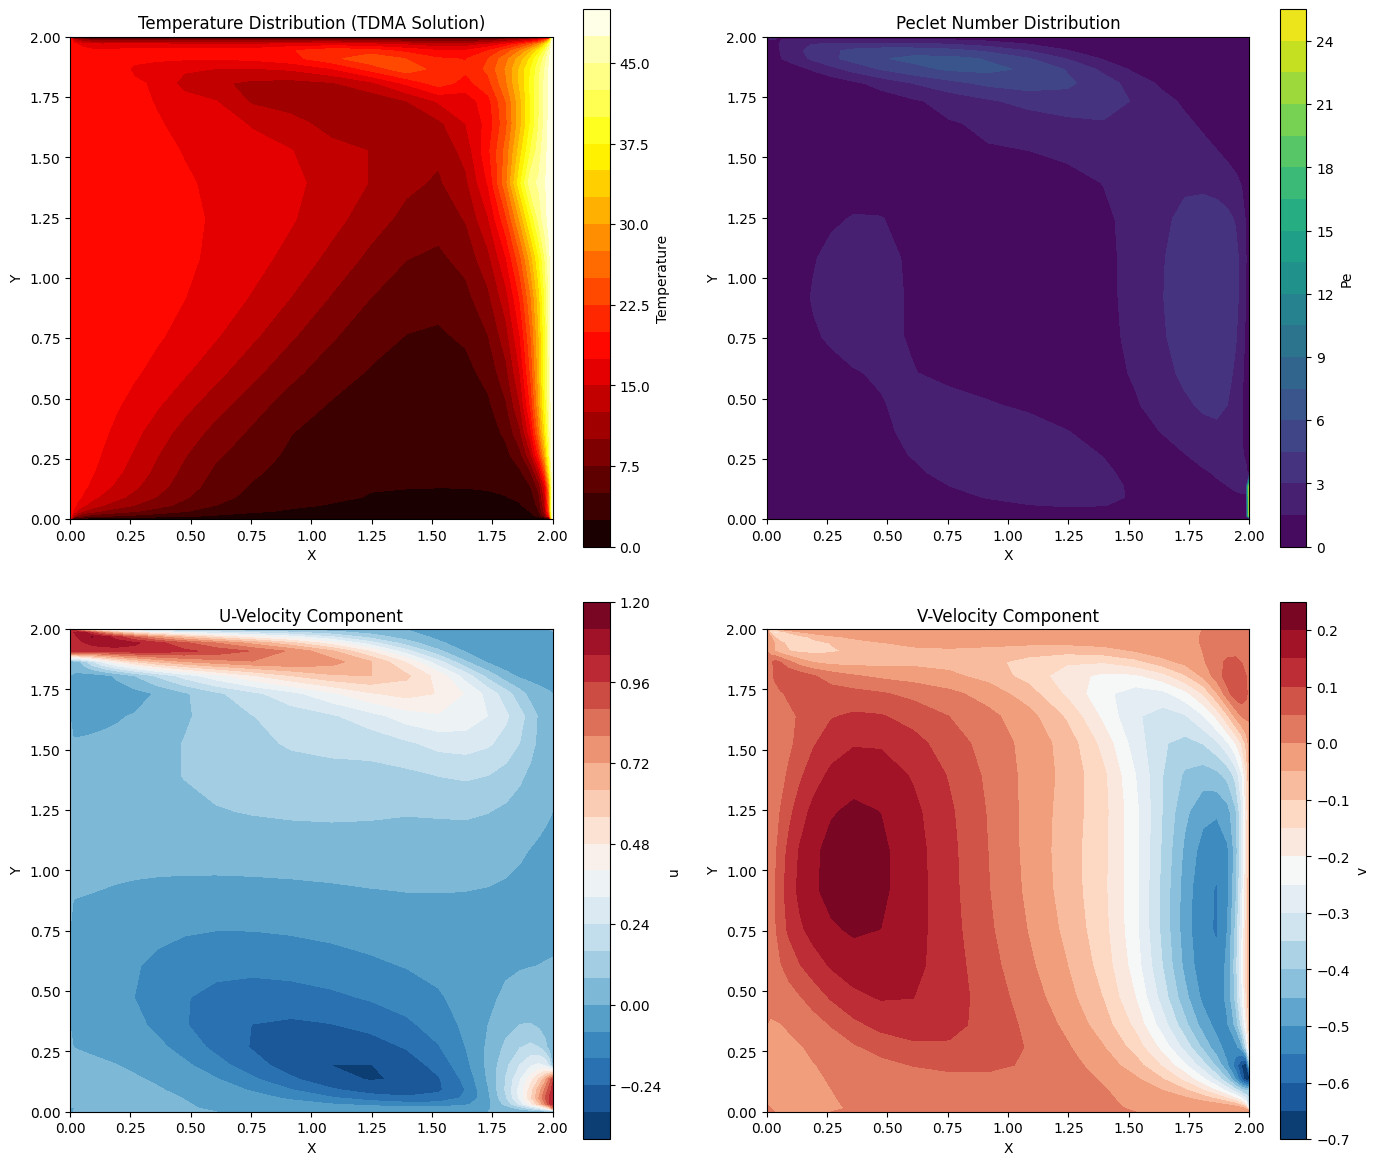


Solution statistics:
  Temperature range: [0.00, 50.00]
  Peclet number range: [0.00, 25.37]
  U-velocity range: [-0.3258, 1.1215]
  V-velocity range: [-0.6897, 0.2237]

Solution completed successfully!


In [456]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load data ---
xc = np.loadtxt('xc.dat')  # grid lines in x (faces) length = nim1
yc = np.loadtxt('yc.dat')  # grid lines in y (faces) length = njm1
u = np.loadtxt('u.dat')    # velocities in MATLAB column-major ordering, length = ni*nj
v = np.loadtxt('v.dat')

# --- Grid bookkeeping ---
nim1 = len(xc)
ni = nim1 + 1
njm1 = len(yc)
nj = njm1 + 1

# reshape velocity arrays (MATLAB column-major => order='F')
u2d = np.reshape(u, (ni, nj), order='F')
v2d = np.reshape(v, (ni, nj), order='F')

# Parameters
rho = 1
k = 1
gamma = 0.02
Ua = 1
Vd = 100
Ub = 0
Uc = 1
T_right_boundary_value = 50
T_left_boundary_value = 20
T_top_boundary_value = 0
T_bottom_boundary_value = 0
ep = 1e-5

def local_Pe(rho, u_e, u_w, v_n, v_s, del_xe, del_xw, del_xn, del_xs, k_over_cp=1/50):
    factor = rho / k_over_cp
    Pe_e = factor * u_e * del_xe
    Pe_w = factor * u_w * del_xw
    Pe_n = factor * v_n * del_xn
    Pe_s = factor * v_s * del_xs
    Pe_x = (Pe_e + Pe_w) / 2
    Pe_y = (Pe_n + Pe_s) / 2
    Pe_local = np.sqrt(Pe_x**2 + Pe_y**2)
    return Pe_local

def TDMA(aW_or_aS, aP, aE_or_aN, b):
    """
    Tridiagonal Matrix Algorithm (Thomas algorithm)
    Solves a tridiagonal system of equations
    """
    n = len(b)
    P = np.zeros(n)
    Q = np.zeros(n)
    phi = np.zeros(n)
    
    # Forward elimination
    P[0] = aE_or_aN[0] / aP[0]
    Q[0] = b[0] / aP[0]
    for i in range(1, n):
        denom = aP[i] - aW_or_aS[i] * P[i-1]
        P[i] = aE_or_aN[i] / denom
        Q[i] = (b[i] + aW_or_aS[i] * Q[i-1]) / denom
    
    # Back substitution
    phi[-1] = Q[-1]
    for i in range(n-2, -1, -1):
        phi[i] = P[i] * phi[i+1] + Q[i]
    
    return phi

Nx = 26
Ny = 26
grid_shape = [Nx, Ny]

# Initialize temperature field with boundary conditions
T_2d = np.zeros((grid_shape[1], grid_shape[0]))
T_2d[:, 0] = T_left_boundary_value  # Left boundary
T_2d[:, -1] = T_right_boundary_value  # Right boundary
T_2d[0, :] = T_bottom_boundary_value  # Bottom boundary
T_2d[-1, :] = T_top_boundary_value  # Top boundary

# Iterative solver parameters
max_iterations = 1000
tolerance = 1e-6
under_relaxation = 0.7  # Under-relaxation factor for stability

Pe_history = []

for iteration in range(max_iterations):
    T_old = T_2d.copy()
    
    # Sweep through each horizontal line (left to right)
    for y in range(grid_shape[1]):
        a_W_line = np.zeros(grid_shape[0])
        a_P_line = np.zeros(grid_shape[0])
        a_E_line = np.zeros(grid_shape[0])
        b_line = np.zeros(grid_shape[0])
        
        for x in range(grid_shape[0]):
            n = y * grid_shape[0] + x
            del_xe, del_xw, del_xn, del_xs = [None]*4
            a_e = a_w = a_n = a_s = 0.0
            
            # Calculate grid spacing
            if x == 0:
                del_xw = xc[0]/2
            if x == grid_shape[0]-1:
                del_xe = xc[-1]/2
            if y == 0:
                del_xs = yc[0]/2
            if y == grid_shape[1]-1:
                del_xn = yc[-1]/2
            
            if del_xw is None and x > 0:
                del_xw = xc[x] - xc[x-1]
            if del_xe is None and x < grid_shape[0]-1:
                del_xe = xc[x+1] - xc[x]
            if del_xs is None and y > 0:
                del_xs = yc[y] - yc[y-1]
            if del_xn is None and y < grid_shape[1]-1:
                del_xn = yc[y+1] - yc[y]
            
            # Get velocities at faces (accounting for staggered grid if any)
            u_e = u2d[y, x+1] #if x < grid_shape[0]-1 else 0.0
            u_w = u2d[y, x] #if x > 0 else 0.0
            v_n = v2d[y, x]# if y > 0 else 0.0
            v_s = v2d[y+1, x] #if y < grid_shape[1]-1 else 0.0
            
            # Calculate Peclet number (only on first iteration)
            if iteration == 0:
                Pe = local_Pe(
                    rho,
                    u_e = u_e,
                    u_w = u_w,
                    v_n = v_n,
                    v_s = v_s,
                    del_xe = del_xe if del_xe else ep,
                    del_xw = del_xw if del_xw else ep,
                    del_xn = del_xn if del_xn else ep,
                    del_xs = del_xs if del_xs else ep
                )
                Pe_history.append(Pe)
            else:
                Pe = Pe_history[n]
            
            # Convection Terms (mass flow rates through faces)
            Fe = rho * u_e
            Fw = rho * u_w
            Fn = rho * v_n
            Fs = rho * v_s
            
            # Special velocity boundary conditions
            if x == 0 and y == 0:
                Fw = rho * Ua
            if y == 0 and x == 13:
                Fs = rho * Vd
            if y == grid_shape[1]-1 and x == 0:
                Fw = rho * Ub
            if y == grid_shape[1]-1 and x == grid_shape[0]-1:
                Fw = rho * Uc
            
            # Diffusion Terms
            Dn = gamma / (del_xn + ep) 
            Ds = gamma / (del_xs + ep) 
            De = gamma / (del_xe + ep) 
            Dw = gamma / (del_xw + ep) 
            
            # Scheme selection based on Peclet number
            if Pe < 2:
                # Central Difference Scheme
                a_n = -Fn/2 + Dn
                a_s = Fs/2 + Ds
                a_e = -Fe/2 + De
                a_w = Fw/2 + Dw
                a_p = a_n + a_s + a_e + a_w
            else:
                # Upwind Scheme
                a_e = De if Fe >= 0 else De + abs(Fe)
                a_w = Dw + Fw if Fw >= 0 else Dw
                a_n = Dn if Fn >= 0 else Dn + abs(Fn)
                a_s = Ds + Fs if Fs >= 0 else Ds
                a_p = a_e + a_w + a_n + a_s + (Fe - Fw + Fn - Fs)
            
            # Handle boundary conditions
            if x == 0:
                # Left boundary - Dirichlet
                a_W_line[x] = 0.0
                a_P_line[x] = 1.0
                a_E_line[x] = 0.0
                b_line[x] = T_left_boundary_value
            elif x == grid_shape[0]-1:
                # Right boundary - Dirichlet
                a_W_line[x] = 0.0
                a_P_line[x] = 1.0
                a_E_line[x] = 0.0
                b_line[x] = T_right_boundary_value
            elif y == 0:
                # Bottom boundary - Dirichlet
                a_W_line[x] = 0.0
                a_P_line[x] = 1.0
                a_E_line[x] = 0.0
                b_line[x] = T_bottom_boundary_value
            elif y == grid_shape[1]-1:
                # Top boundary - Dirichlet
                a_W_line[x] = 0.0
                a_P_line[x] = 1.0
                a_E_line[x] = 0.0
                b_line[x] = T_top_boundary_value
            else:
                # Interior points
                # For line-by-line TDMA in x-direction:
                # a_W corresponds to west neighbor (x-1)
                # a_E corresponds to east neighbor (x+1)
                # North and south contributions go to source term
                a_W_line[x] = a_w
                a_P_line[x] = a_p
                a_E_line[x] = a_e
                
                # Source term includes contributions from north and south neighbors
                b_source = 0.0
                if y > 0:
                    b_source += a_n * T_old[y-1, x]  # North neighbor
                if y < grid_shape[1]-1:
                    b_source += a_s * T_old[y+1, x]  # South neighbor
                
                b_line[x] = b_source
        
        # Solve the line using TDMA
        T_line = TDMA(a_W_line, a_P_line, a_E_line, b_line)
        
        # Update with under-relaxation
        T_2d[y, :] = under_relaxation * T_line + (1 - under_relaxation) * T_old[y, :]
    
    # Check convergence
    residual = np.max(np.abs(T_2d - T_old))
    if iteration % 50 == 0:
        print(f"Iteration {iteration}: Max residual = {residual:.2e}")
    
    if residual < tolerance:
        print(f"\nConverged in {iteration+1} iterations!")
        break
else:
    print(f"\nWarning: Did not converge in {max_iterations} iterations. Final residual: {residual:.2e}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Temperature contour plot
im1 = axes[0, 0].contourf(xc, yc, T_2d, levels=20, cmap='hot')
axes[0, 0].set_xlabel('X')
axes[0, 0].set_ylabel('Y')
axes[0, 0].set_title('Temperature Distribution (TDMA Solution)')
axes[0, 0].set_aspect('equal')
plt.colorbar(im1, ax=axes[0, 0], label='Temperature')

# Peclet number distribution
Pe_2d = np.array(Pe_history).reshape((grid_shape[1], grid_shape[0]))
im2 = axes[0, 1].contourf(xc, yc, Pe_2d, levels=20, cmap='viridis')
axes[0, 1].set_xlabel('X')
axes[0, 1].set_ylabel('Y')
axes[0, 1].set_title('Peclet Number Distribution')
axes[0, 1].set_aspect('equal')
plt.colorbar(im2, ax=axes[0, 1], label='Pe')

# Velocity field (u-component)
u_plot = u2d[:grid_shape[1], :grid_shape[0]]
im3 = axes[1, 0].contourf(xc, yc, u_plot, levels=20, cmap='RdBu_r')
axes[1, 0].set_xlabel('X')
axes[1, 0].set_ylabel('Y')
axes[1, 0].set_title('U-Velocity Component')
axes[1, 0].set_aspect('equal')
plt.colorbar(im3, ax=axes[1, 0], label='u')

# Velocity field (v-component)
v_plot = v2d[:grid_shape[1], :grid_shape[0]]
im4 = axes[1, 1].contourf(xc, yc, v_plot, levels=20, cmap='RdBu_r')
axes[1, 1].set_xlabel('X')
axes[1, 1].set_ylabel('Y')
axes[1, 1].set_title('V-Velocity Component')
axes[1, 1].set_aspect('equal')
plt.colorbar(im4, ax=axes[1, 1], label='v')

plt.tight_layout()
plt.savefig('temperature_tdma_solution.png', dpi=150)
plt.show()

print(f"\nSolution statistics:")
print(f"  Temperature range: [{T_2d.min():.2f}, {T_2d.max():.2f}]")
print(f"  Peclet number range: [{min(Pe_history):.2f}, {max(Pe_history):.2f}]")
print(f"  U-velocity range: [{u_plot.min():.4f}, {u_plot.max():.4f}]")
print(f"  V-velocity range: [{v_plot.min():.4f}, {v_plot.max():.4f}]")
print(f"\nSolution completed successfully!")

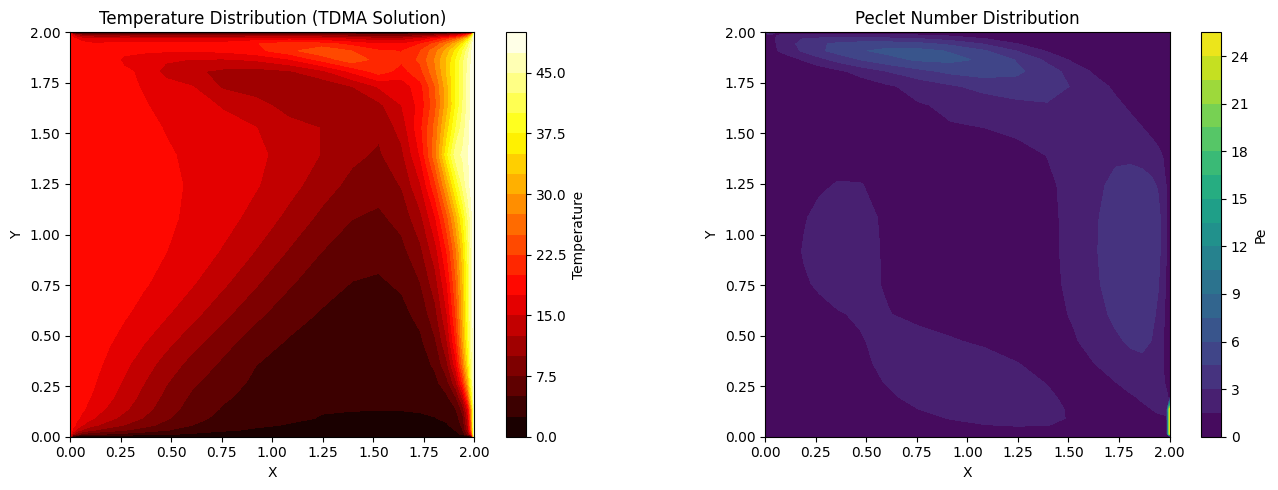


Solution statistics:
  Temperature range: [0.00, 50.00]
  Peclet number range: [0.00, 25.37]

Solution completed successfully!


In [457]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Temperature contour plot
im1 = axes[0].contourf(xc, yc, T_2d, levels=20, cmap='hot')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_title('Temperature Distribution (TDMA Solution)')
axes[0].set_aspect('equal')
plt.colorbar(im1, ax=axes[0], label='Temperature')

# Peclet number distribution
Pe_2d = np.array(Pe_history).reshape((grid_shape[1], grid_shape[0]))
im2 = axes[1].contourf(xc, yc, Pe_2d, levels=20, cmap='viridis')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_title('Peclet Number Distribution')
axes[1].set_aspect('equal')
plt.colorbar(im2, ax=axes[1], label='Pe')

plt.tight_layout()
plt.savefig('temperature_tdma_solution.png', dpi=150)
plt.show()

print(f"\nSolution statistics:")
print(f"  Temperature range: [{T_2d.min():.2f}, {T_2d.max():.2f}]")
print(f"  Peclet number range: [{min(Pe_history):.2f}, {max(Pe_history):.2f}]")
print(f"\nSolution completed successfully!")